In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

# Utils

In [2]:
def imshow(*args, title=None, figsize=20, to_rgb=True, fontsize=12):
    if isinstance(figsize, int):
        figsize = (figsize, figsize)
    images = args[0] if type(args[0]) is list else list(args)
    if to_rgb:
        images = list(map(lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB), images))
    if title is not None:
        assert len(title) == len(images), "Please provide a title for each image."
    plt.figure(figsize=figsize)
    for i in range(1, len(images)+1):
        plt.subplot(1, len(images), i)
        if title is not None:
            plt.title(title[i-1], fontsize=fontsize)
        if images[i-1].ndim == 2:
            plt.imshow(images[i-1], cmap='gray')
        else:
            plt.imshow(images[i-1])
        plt.axis('off')

In [3]:
def hist(image):
	m, n = image.shape
	hist = [0.0] * 256
	for i in range(m):
		for j in range(n):
			hist[image[i, j]]+=1
	return np.array(hist)/(m*n)

In [4]:
def histeq(img):
	h = hist(img)
	cumsum = np.cumsum(h)
	sk = np.uint8(255 * cumsum)
	w, h = img.shape
	result = np.zeros_like(img)
	for i in range(0, w):
		for j in range(0, h):
			result[i, j] = sk[img[i, j]]
	return result, hist(result)

In [5]:
def normalize(x):
    return (((x - x.min()) / (x.max() - x.min())) * 255).astype('uint8')

# 2.1 Histogram Equalization

## 2.1.1 histogram as a stem plot

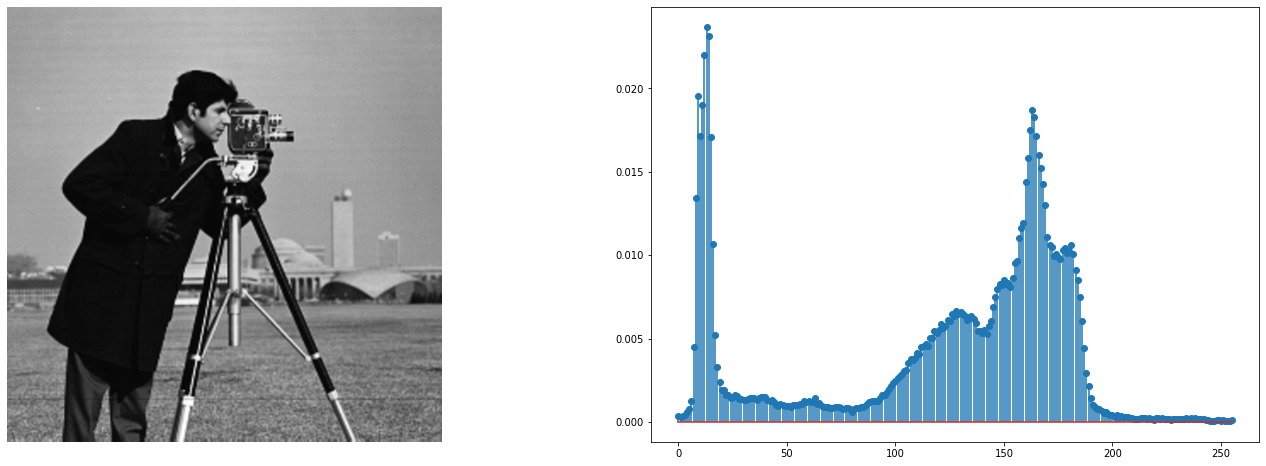

In [6]:
camera_man = cv2.imread('Camera Man.bmp', cv2.IMREAD_GRAYSCALE)
camera_man_hist = hist(camera_man)

plt.figure(figsize=(24, 8))

plt.subplot(1, 2, 1)
plt.imshow(camera_man, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.stem(camera_man_hist, use_line_collection=True)

plt.show()

### 2.1.1.1 decrease brightness

In [7]:
D = (camera_man // 3).astype('uint8')

### 2.1.1.2 histograms of orignial image and D

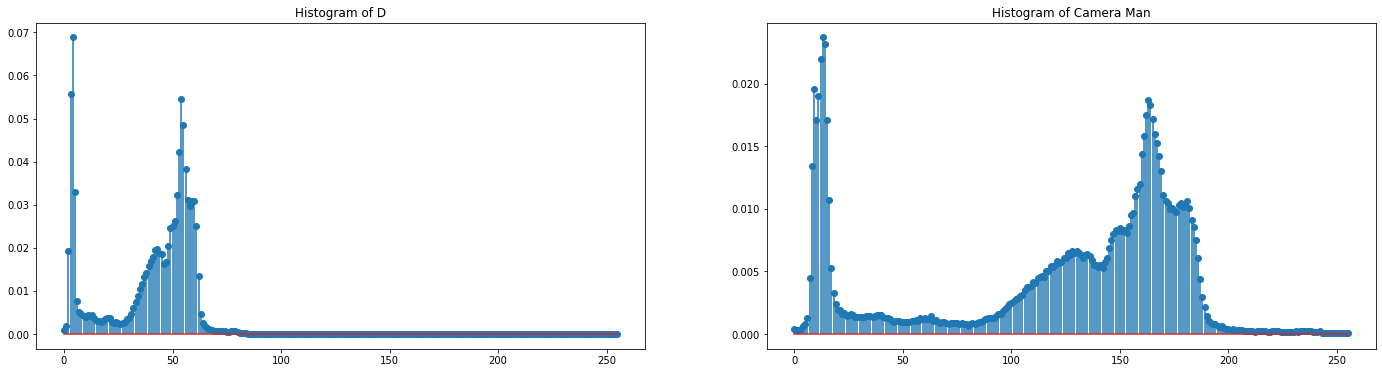

In [8]:
plt.figure(figsize=(24, 6))

plt.subplot(1, 2, 1)
plt.stem(hist(D), use_line_collection=True)
plt.title('Histogram of D')

plt.subplot(1, 2, 2)
plt.stem(camera_man_hist, use_line_collection=True)
plt.title('Histogram of Camera Man')

plt.show()

### 2.1.1.3 histogram equalization on D

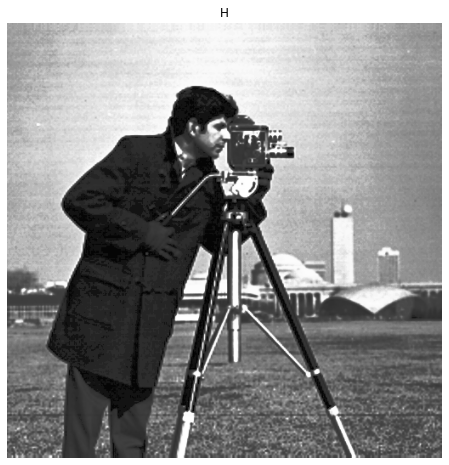

In [9]:
H, h_hist = histeq(D)
imshow(H, figsize=8, title=['H'])

### 2.1.1.4 local histogram equalization

In [10]:
def adaptive_histeq(im, window_x=8, window_y=8):        
    h, w = im.shape
    result = np.zeros(im.shape)
    for i in range(0, h):
        for j in range(0, w):
            # Get the block
            blk = im[i: min(i + window_x, h), j: min(j + window_y, w)]
            probs = get_distr(blk)
            result[i: min(i + window_x, h), j: min(j + window_y, w)] = CHE(blk, probs)
    result = np.clip(result, 0, 256).astype('uint8')
    return result

def CHE(im, probs):
    T = np.array(list(map(int, 255*np.cumsum(probs))))
    return T[im]

def get_distr(im):
   hist, _ = np.histogram(im.flatten(), 256, [0,256])
   return hist / hist.sum()

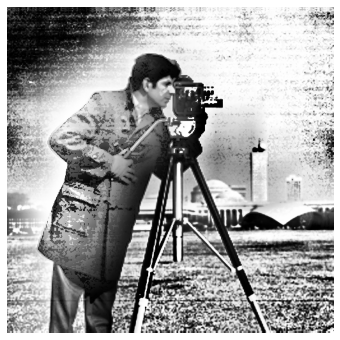

In [11]:
L = adaptive_histeq(D, 80, 80)
imshow(L, figsize=6)

### 2.1.1.5 histograms of H and L

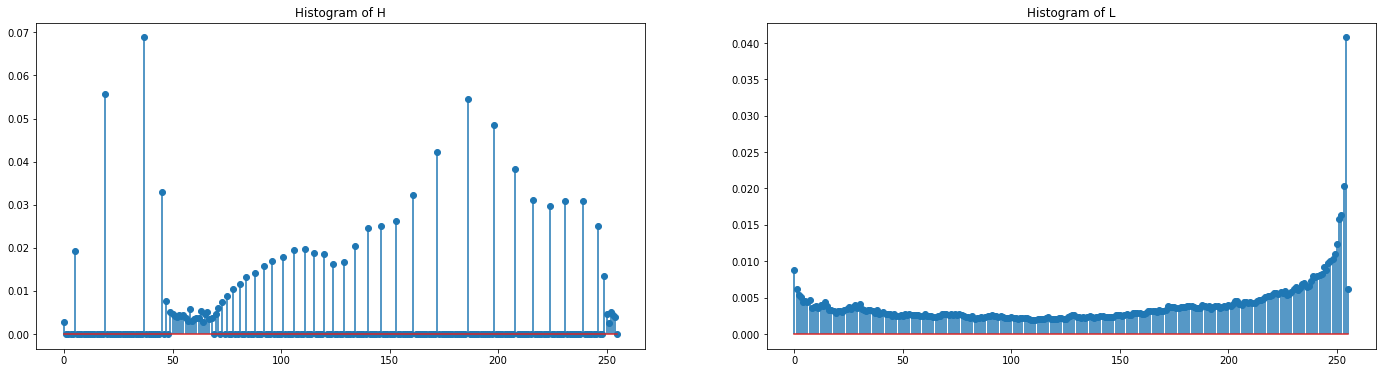

In [12]:
plt.figure(figsize=(24, 6))

plt.subplot(1, 2, 1)
plt.stem(hist(H), use_line_collection=True)
plt.title('Histogram of H')

plt.subplot(1, 2, 2)
plt.stem(hist(L), use_line_collection=True)
plt.title('Histogram of L')

plt.show()

### 2.1.1.6 log, inverse & power-law transform

In [13]:
def log_transform(img, c=None):
    img = img.copy().astype('float32')
    if c is None:
        c = 255 / float(np.log(img.max() + 1))
    return np.clip(c * np.log(img + 1), 0, 256).astype('uint8')

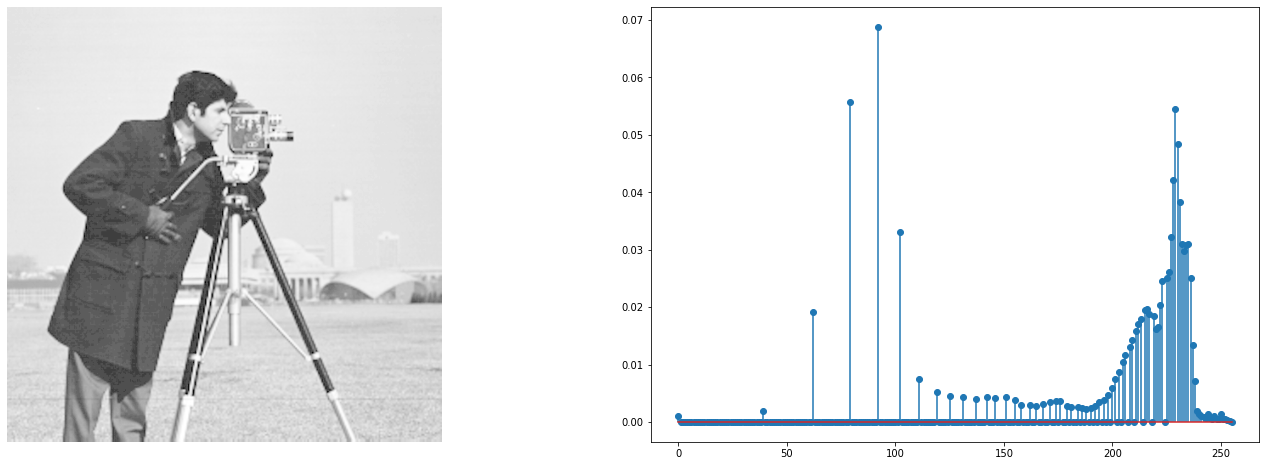

In [14]:
img_log = log_transform(D)

plt.figure(figsize=(24, 8))

plt.subplot(1, 2, 1)
plt.imshow(img_log, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.stem(hist(img_log), use_line_collection=True)

plt.show()

In [15]:
def ilog_transform(img, c=None):
    img = img.copy().astype('float32')
    if c is None:
        c = 255 / math.log(256, 10)
    return normalize(10 ** (img / c))

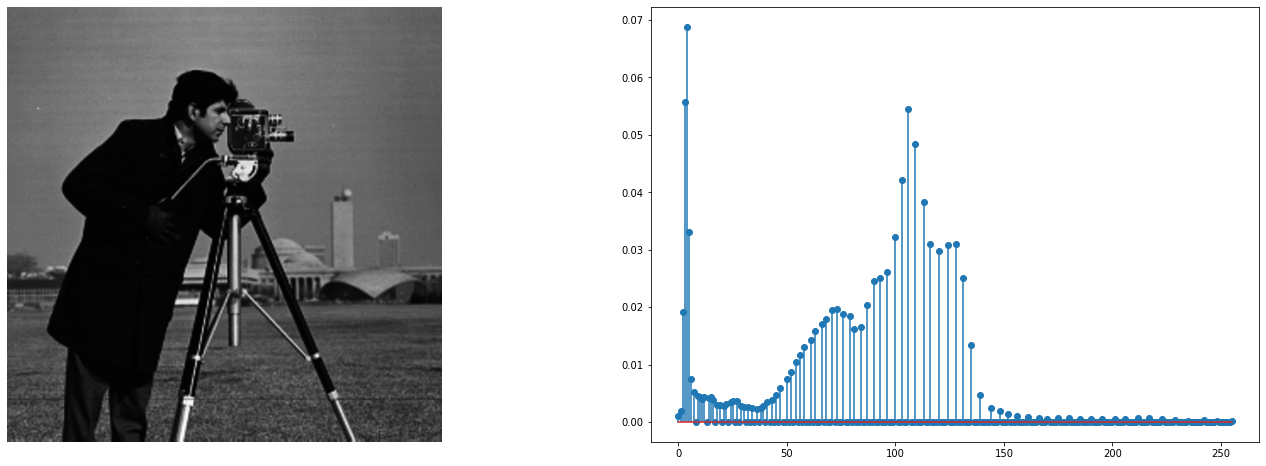

In [16]:
img_ilog = ilog_transform(D)

plt.figure(figsize=(24, 8))

plt.subplot(1, 2, 1)
plt.imshow(img_ilog, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.stem(hist(img_ilog), use_line_collection=True)

plt.show()

In [17]:
def gamma_transform(img, gamma, c=1):
    img = img.copy().astype('float32')
    return normalize(c * (img ** gamma))

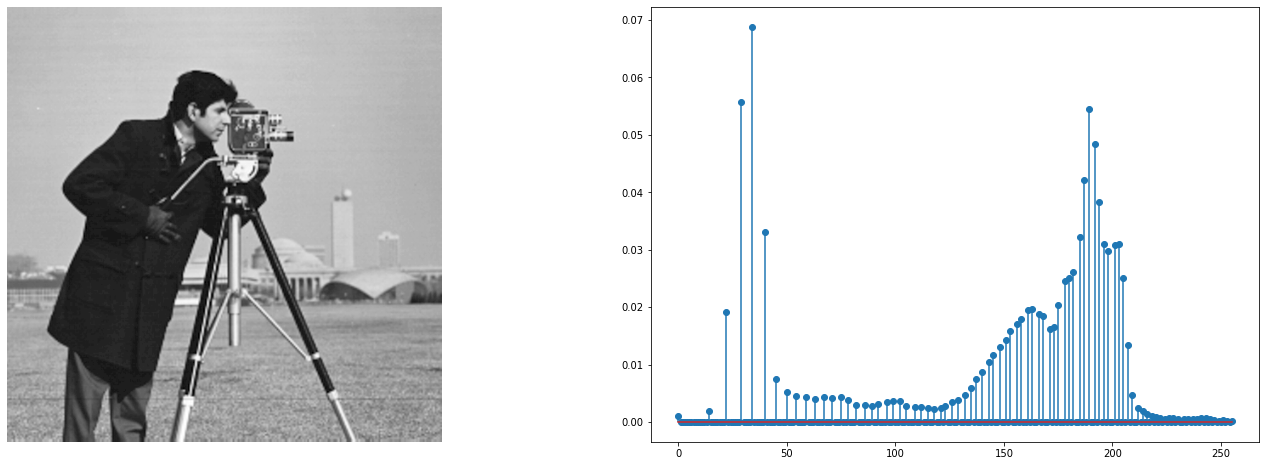

In [18]:
img_gamma = gamma_transform(D, gamma=0.65)

plt.figure(figsize=(24, 8))

plt.subplot(1, 2, 1)
plt.imshow(img_gamma, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.stem(hist(img_gamma), use_line_collection=True)

plt.show()

## 2.1.2 histogram equalization on Camera Man

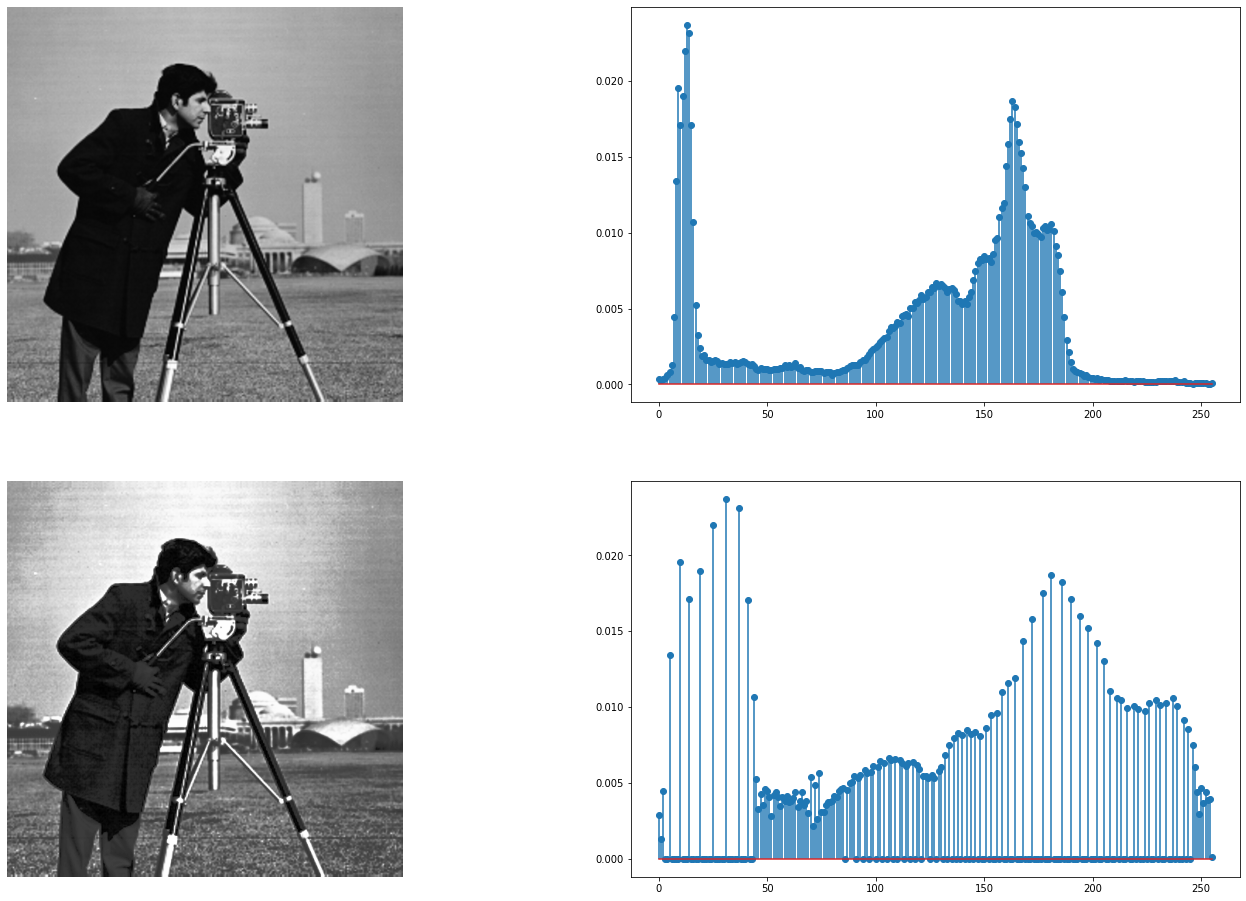

In [19]:
camera_man = cv2.imread('Camera Man.bmp', cv2.IMREAD_GRAYSCALE)
camera_man_hist = hist(camera_man)

camera_man_eq, camera_man_eq_hist = histeq(camera_man)

plt.figure(figsize=(24, 16))

plt.subplot(2, 2, 1)
plt.imshow(camera_man, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.stem(camera_man_hist, use_line_collection=True)

plt.subplot(2, 2, 3)
plt.imshow(camera_man_eq, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.stem(camera_man_eq_hist, use_line_collection=True)

plt.show()

# 2.2 Local Histogram Equalization

## 2.2.1 local histogram equalization with different windows size

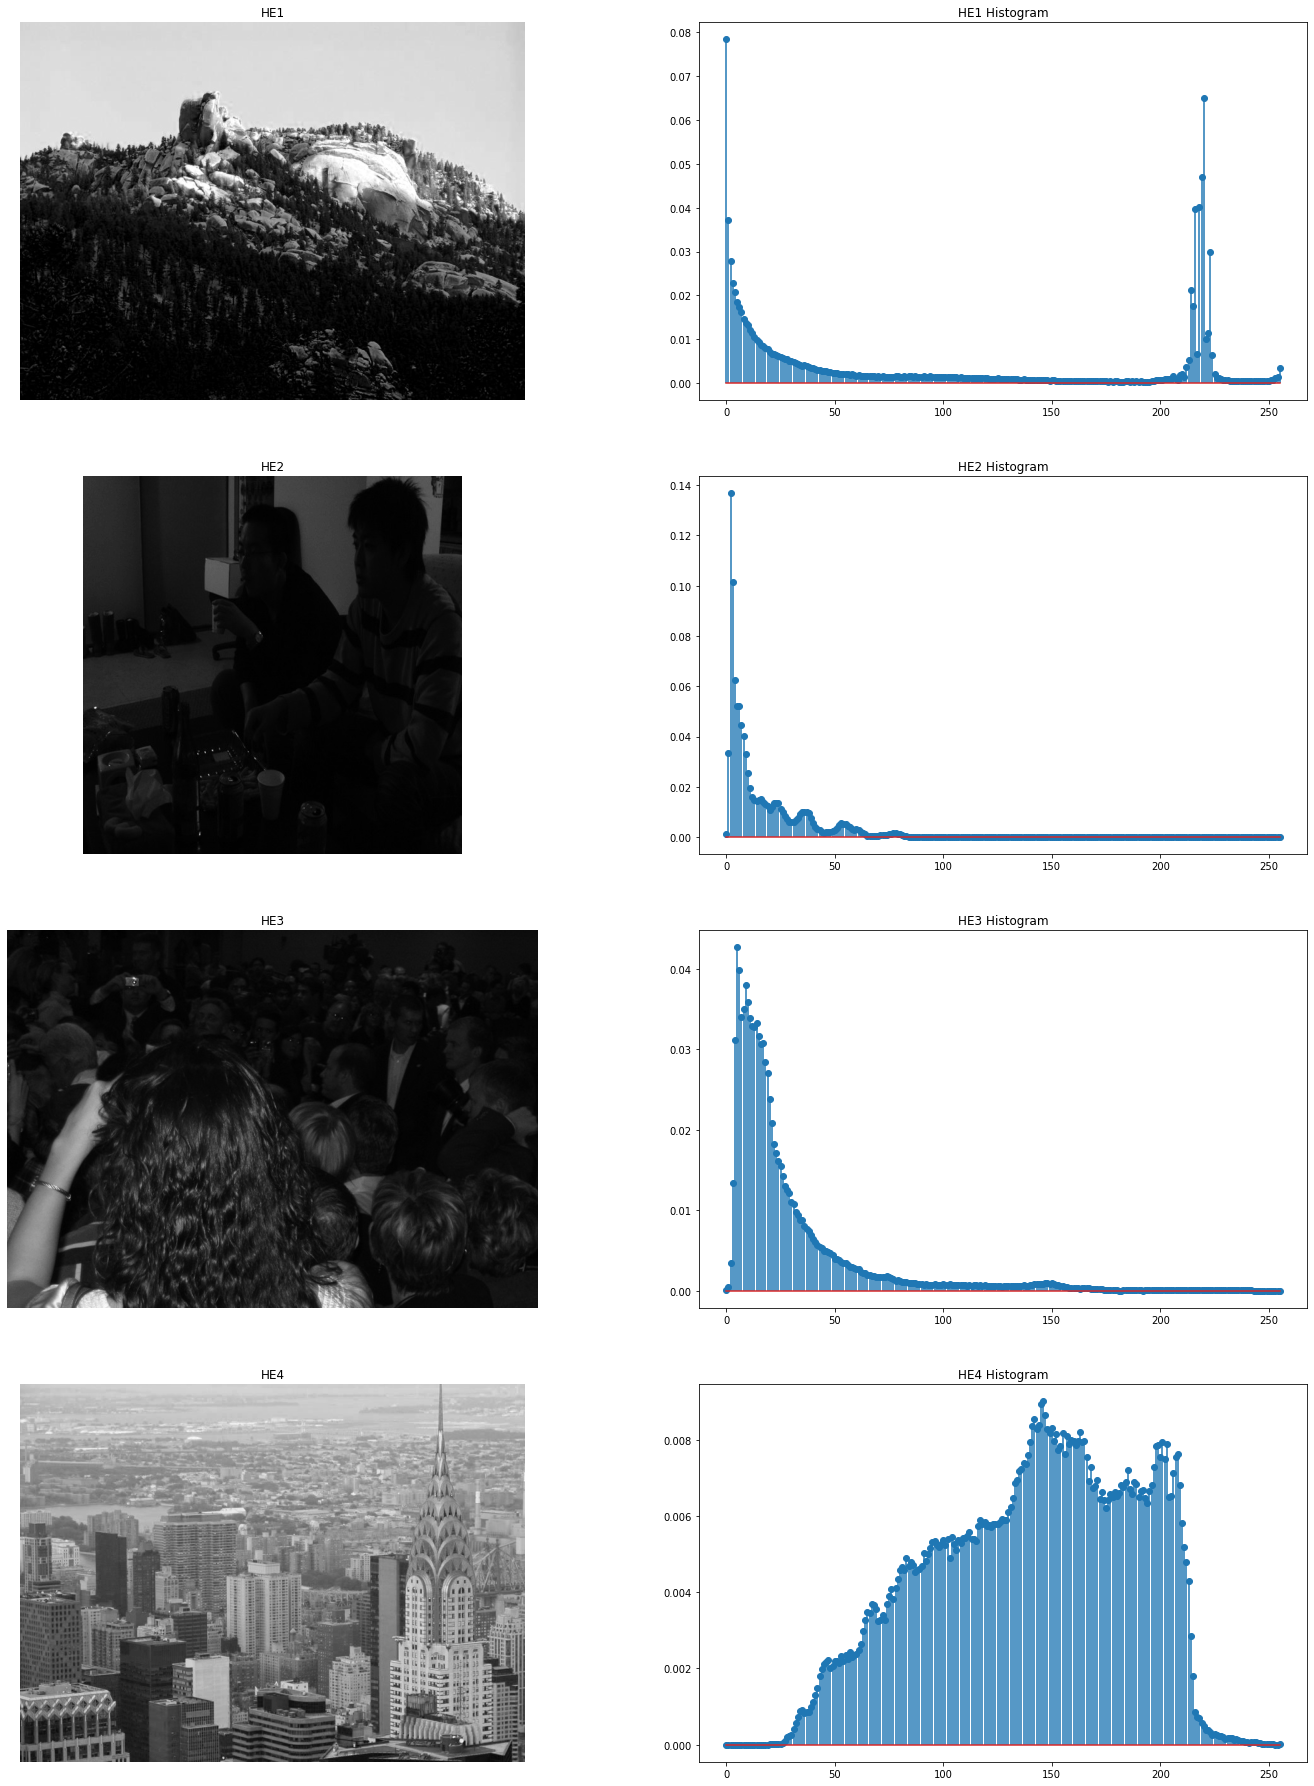

In [20]:
he1 = cv2.imread('HE1.jpg', cv2.IMREAD_GRAYSCALE)
he2 = cv2.imread('HE2.jpg', cv2.IMREAD_GRAYSCALE)
he3 = cv2.imread('HE3.jpg', cv2.IMREAD_GRAYSCALE)
he4 = cv2.imread('HE4.jpg', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(24, 32))

plt.subplot(4, 2, 1)
plt.imshow(he1, cmap='gray')
plt.title('HE1')
plt.axis('off')
plt.subplot(4, 2, 2)
plt.stem(hist(he1), use_line_collection=True)
plt.title('HE1 Histogram')

plt.subplot(4, 2, 3)
plt.imshow(he2, cmap='gray')
plt.title('HE2')
plt.axis('off')
plt.subplot(4, 2, 4)
plt.stem(hist(he2), use_line_collection=True)
plt.title('HE2 Histogram')

plt.subplot(4, 2, 5)
plt.imshow(he3, cmap='gray')
plt.title('HE3')
plt.axis('off')
plt.subplot(4, 2, 6)
plt.stem(hist(he3), use_line_collection=True)
plt.title('HE3 Histogram')

plt.subplot(4, 2, 7)
plt.imshow(he4, cmap='gray')
plt.title('HE4')
plt.axis('off')
plt.subplot(4, 2, 8)
plt.stem(hist(he4), use_line_collection=True)
plt.title('HE4 Histogram')

plt.show()

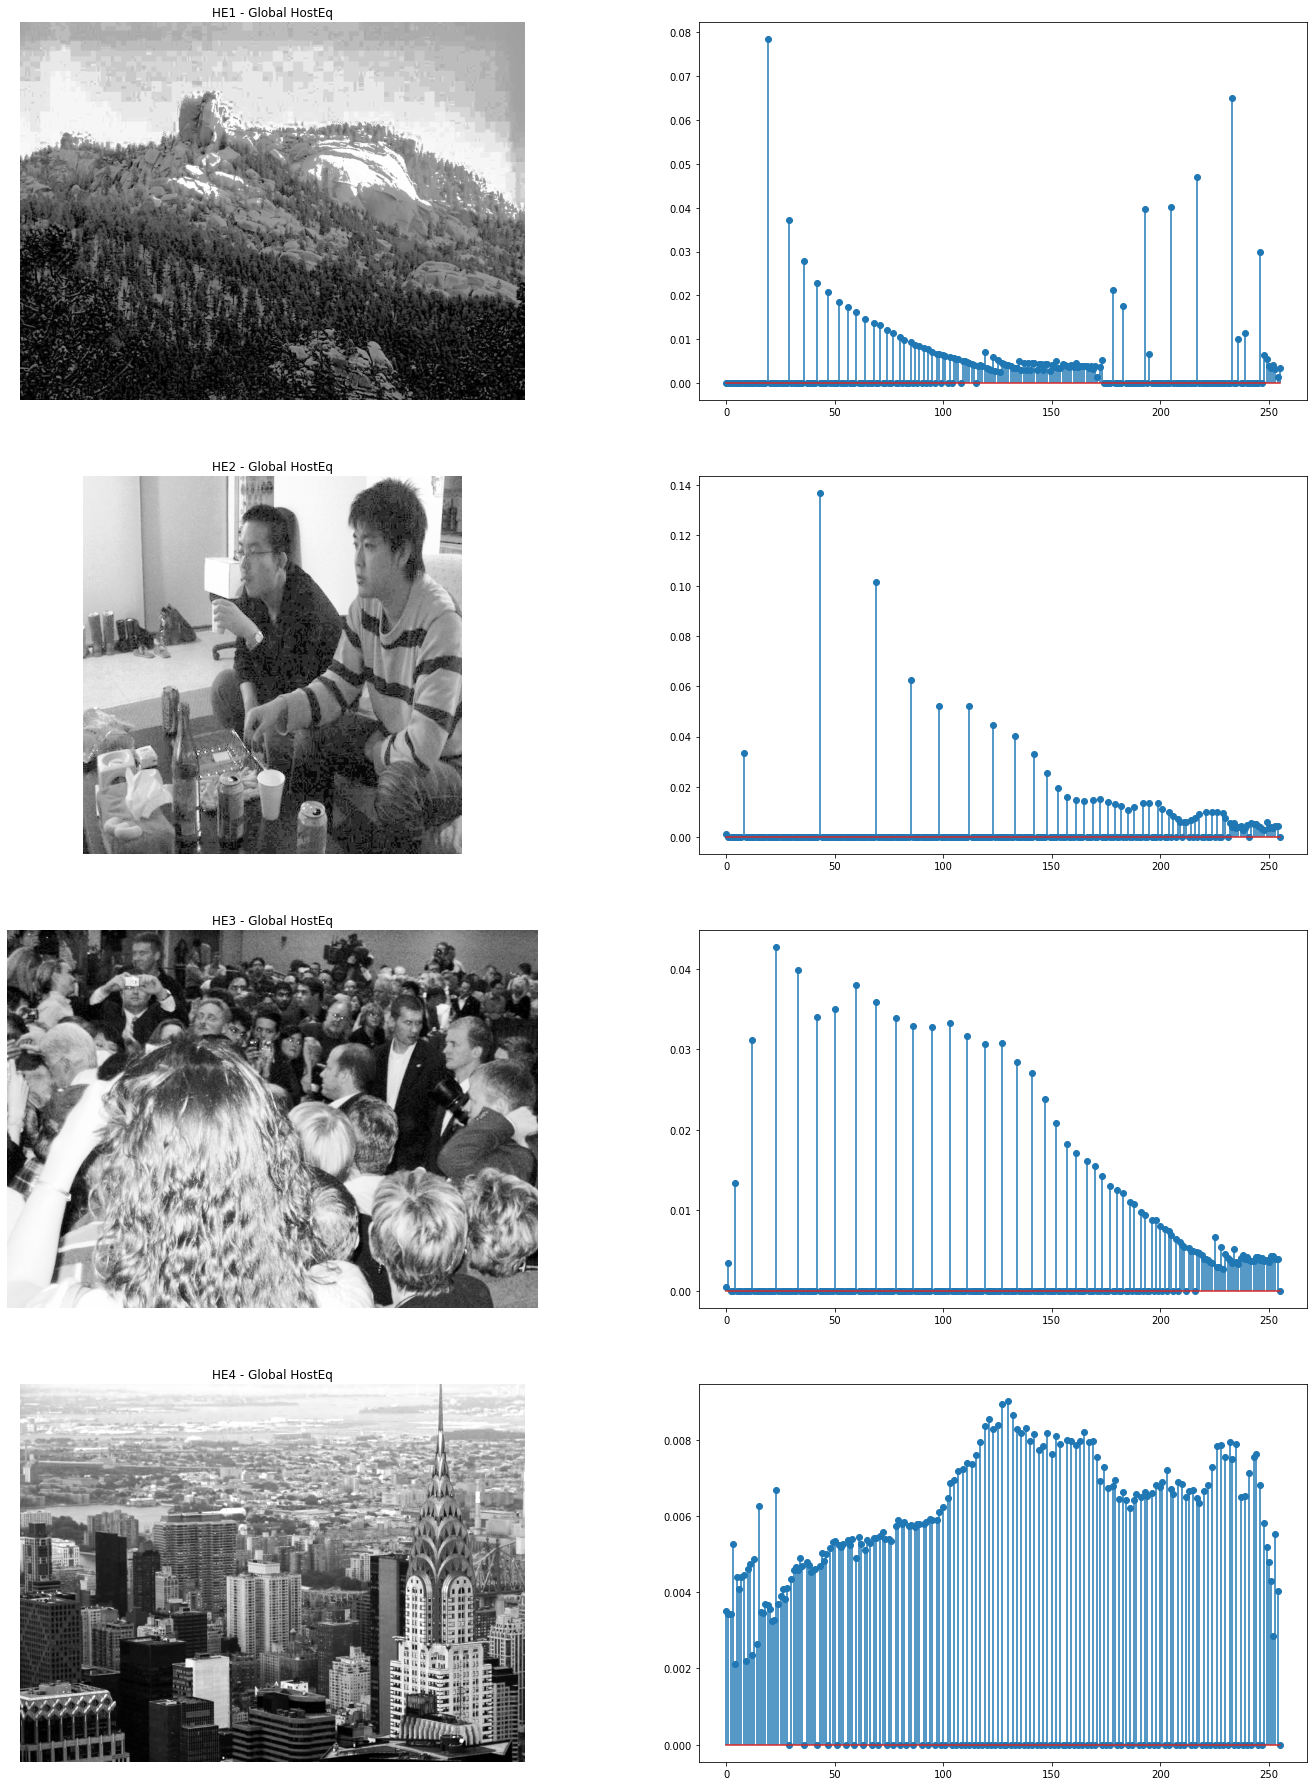

In [21]:
he1_eq_g, _ = histeq(he1)
he2_eq_g, _ = histeq(he2)
he3_eq_g, _ = histeq(he3)
he4_eq_g, _ = histeq(he4)

plt.figure(figsize=(24, 32))

plt.subplot(4, 2, 1)
plt.imshow(he1_eq_g, cmap='gray')
plt.title('HE1 - Global HostEq')
plt.axis('off')
plt.subplot(4, 2, 2)
plt.stem(hist(he1_eq_g), use_line_collection=True)

plt.subplot(4, 2, 3)
plt.imshow(he2_eq_g, cmap='gray')
plt.title('HE2 - Global HostEq')
plt.axis('off')
plt.subplot(4, 2, 4)
plt.stem(hist(he2_eq_g), use_line_collection=True)

plt.subplot(4, 2, 5)
plt.imshow(he3_eq_g, cmap='gray')
plt.title('HE3 - Global HostEq')
plt.axis('off')
plt.subplot(4, 2, 6)
plt.stem(hist(he3_eq_g), use_line_collection=True)

plt.subplot(4, 2, 7)
plt.imshow(he4_eq_g, cmap='gray')
plt.title('HE4 - Global HostEq')
plt.axis('off')
plt.subplot(4, 2, 8)
plt.stem(hist(he4_eq_g), use_line_collection=True)

plt.show()

### window size = 100 * 100

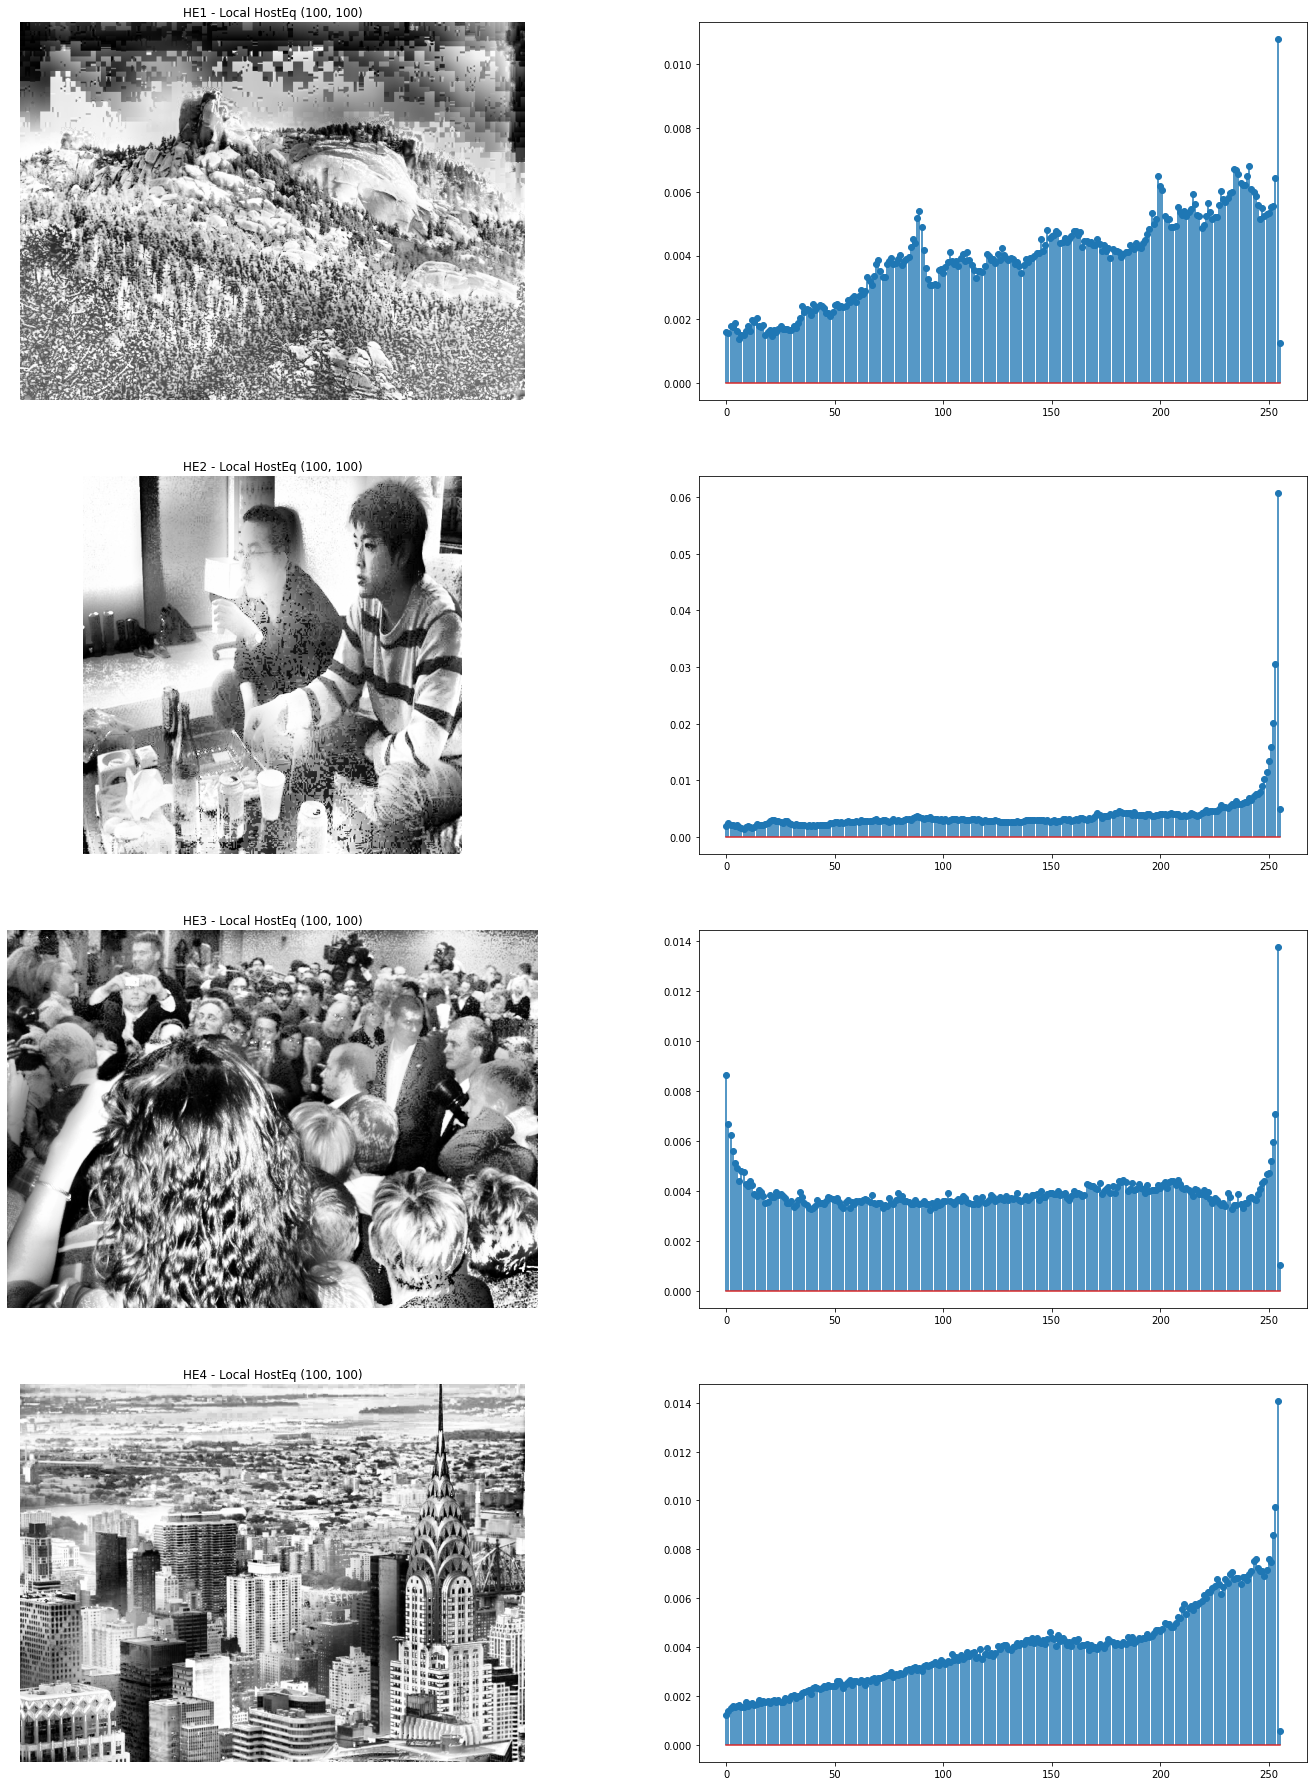

In [22]:
he1_eq_local = adaptive_histeq(he1, 100, 100)
he2_eq_local = adaptive_histeq(he2, 100, 100)
he3_eq_local = adaptive_histeq(he3, 100, 100)
he4_eq_local = adaptive_histeq(he4, 100, 100)

window = ' (100, 100)'

plt.figure(figsize=(24, 32))

plt.subplot(4, 2, 1)
plt.imshow(he1_eq_local, cmap='gray')
plt.title('HE1 - Local HostEq' + window)
plt.axis('off')
plt.subplot(4, 2, 2)
plt.stem(hist(he1_eq_local), use_line_collection=True)

plt.subplot(4, 2, 3)
plt.imshow(he2_eq_local, cmap='gray')
plt.title('HE2 - Local HostEq' + window)
plt.axis('off')
plt.subplot(4, 2, 4)
plt.stem(hist(he2_eq_local), use_line_collection=True)

plt.subplot(4, 2, 5)
plt.imshow(he3_eq_local, cmap='gray')
plt.title('HE3 - Local HostEq' + window)
plt.axis('off')
plt.subplot(4, 2, 6)
plt.stem(hist(he3_eq_local), use_line_collection=True)

plt.subplot(4, 2, 7)
plt.imshow(he4_eq_local, cmap='gray')
plt.title('HE4 - Local HostEq' + window)
plt.axis('off')
plt.subplot(4, 2, 8)
plt.stem(hist(he4_eq_local), use_line_collection=True)

plt.show()

### window size = 200 * 200

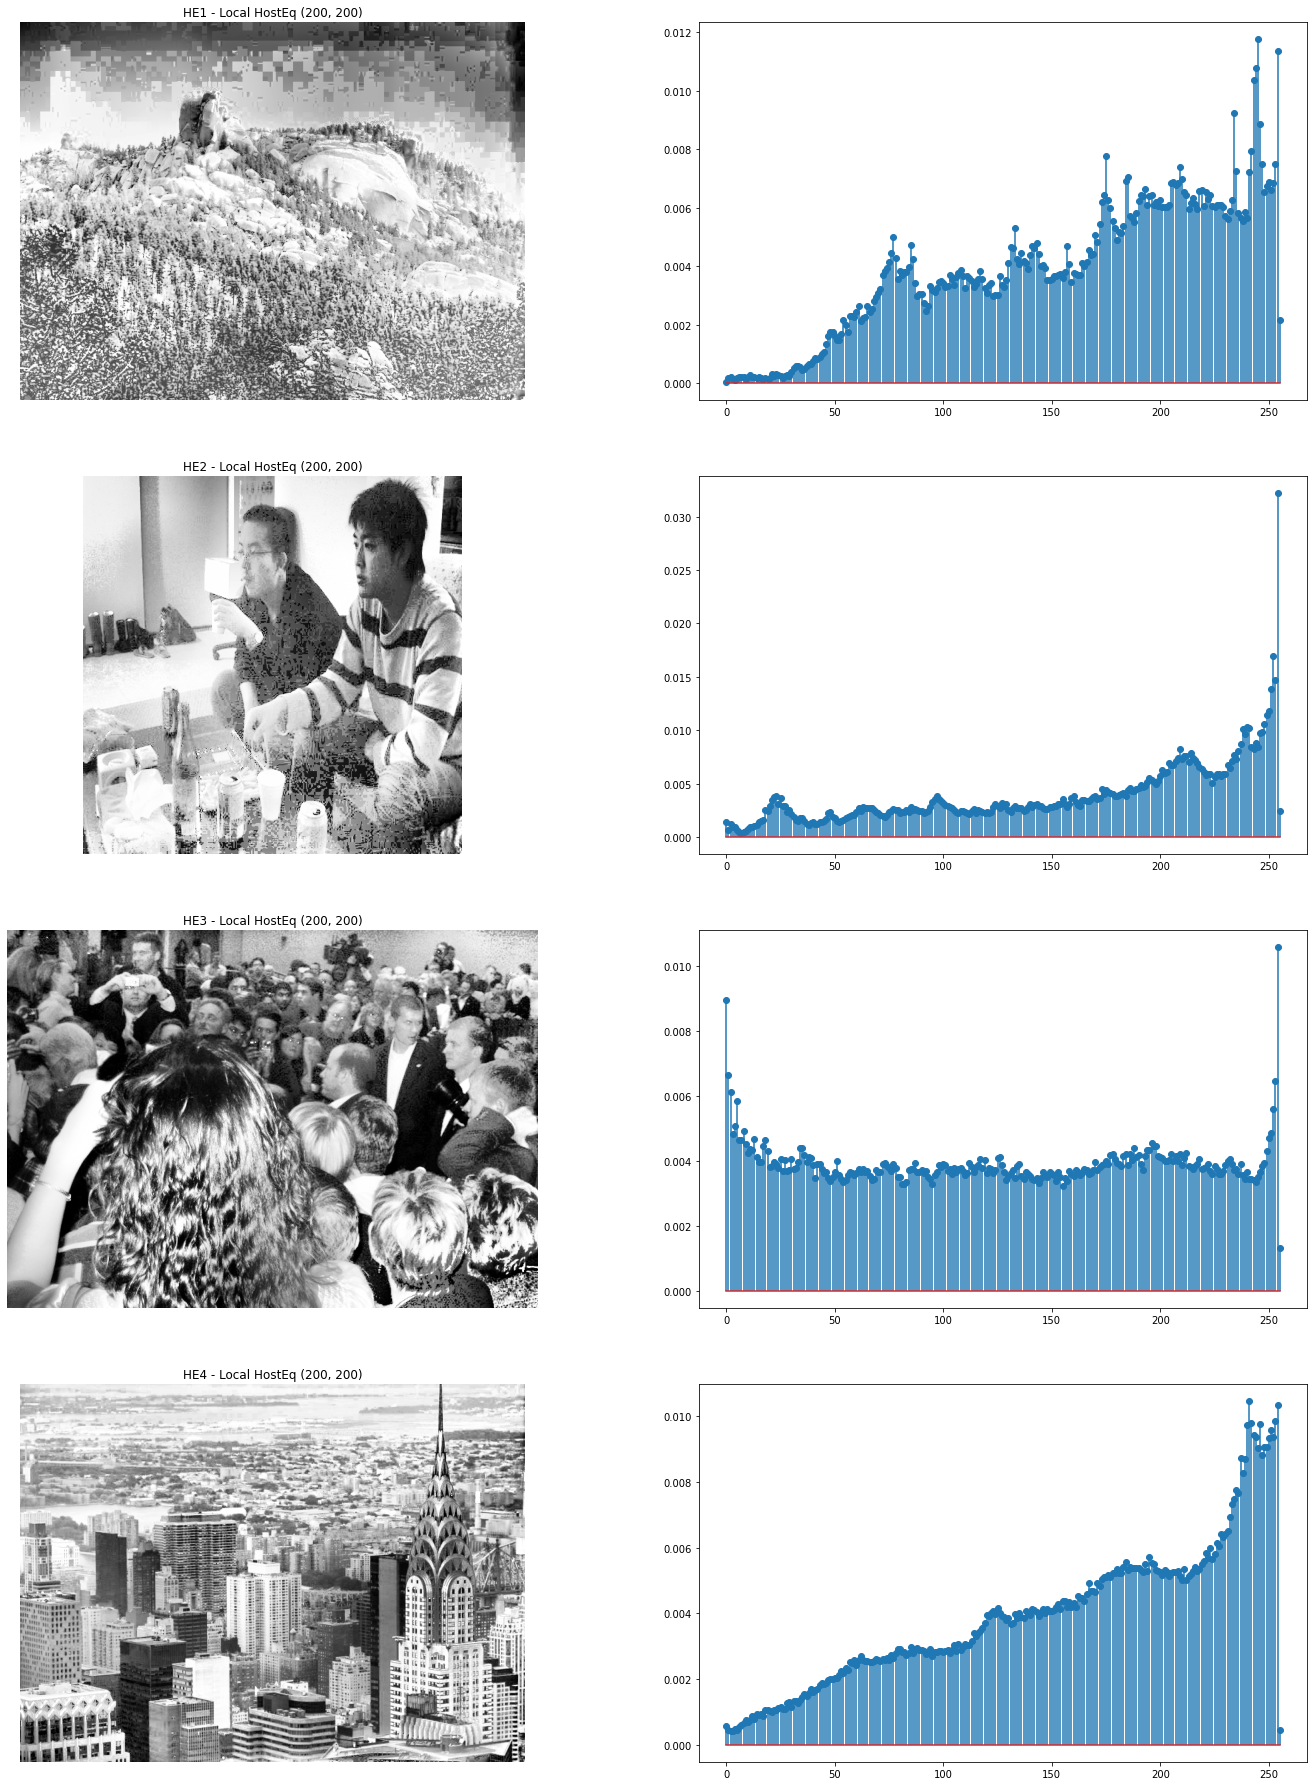

In [ ]:
he1_eq_local = adaptive_histeq(he1, 200, 200)
he2_eq_local = adaptive_histeq(he2, 200, 200)
he3_eq_local = adaptive_histeq(he3, 200, 200)
he4_eq_local = adaptive_histeq(he4, 200, 200)

window = ' (200, 200)'

plt.figure(figsize=(24, 32))

plt.subplot(4, 2, 1)
plt.imshow(he1_eq_local, cmap='gray')
plt.title('HE1 - Local HostEq' + window)
plt.axis('off')
plt.subplot(4, 2, 2)
plt.stem(hist(he1_eq_local), use_line_collection=True)

plt.subplot(4, 2, 3)
plt.imshow(he2_eq_local, cmap='gray')
plt.title('HE2 - Local HostEq' + window)
plt.axis('off')
plt.subplot(4, 2, 4)
plt.stem(hist(he2_eq_local), use_line_collection=True)

plt.subplot(4, 2, 5)
plt.imshow(he3_eq_local, cmap='gray')
plt.title('HE3 - Local HostEq' + window)
plt.axis('off')
plt.subplot(4, 2, 6)
plt.stem(hist(he3_eq_local), use_line_collection=True)

plt.subplot(4, 2, 7)
plt.imshow(he4_eq_local, cmap='gray')
plt.title('HE4 - Local HostEq' + window)
plt.axis('off')
plt.subplot(4, 2, 8)
plt.stem(hist(he4_eq_local), use_line_collection=True)

plt.show()

### window size = 400 * 400

In [ ]:
he1_eq_local = adaptive_histeq(he1, 400, 400)
he2_eq_local = adaptive_histeq(he2, 400, 400)
he3_eq_local = adaptive_histeq(he3, 400, 400)
he4_eq_local = adaptive_histeq(he4, 400, 400)

window = ' (400, 400)'

plt.figure(figsize=(24, 32))

plt.subplot(4, 2, 1)
plt.imshow(he1_eq_local, cmap='gray')
plt.title('HE1 - Local HostEq' + window)
plt.axis('off')
plt.subplot(4, 2, 2)
plt.stem(hist(he1_eq_local), use_line_collection=True)

plt.subplot(4, 2, 3)
plt.imshow(he2_eq_local, cmap='gray')
plt.title('HE2 - Local HostEq' + window)
plt.axis('off')
plt.subplot(4, 2, 4)
plt.stem(hist(he2_eq_local), use_line_collection=True)

plt.subplot(4, 2, 5)
plt.imshow(he3_eq_local, cmap='gray')
plt.title('HE3 - Local HostEq' + window)
plt.axis('off')
plt.subplot(4, 2, 6)
plt.stem(hist(he3_eq_local), use_line_collection=True)

plt.subplot(4, 2, 7)
plt.imshow(he4_eq_local, cmap='gray')
plt.title('HE4 - Local HostEq' + window)
plt.axis('off')
plt.subplot(4, 2, 8)
plt.stem(hist(he4_eq_local), use_line_collection=True)

plt.show()